In [2]:
import warnings
warnings.filterwarnings('ignore')
import classyRF_final as classyRF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
import importlib
importlib.reload(classyRF) 

<module 'classyRF_final' from 'C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\classyRF_final.py'>

In [14]:
pathClassy = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\classy_RF\\"
pathData = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\allEOS\\"
pathMDC = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\"
pathPlots = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\plots_testing_overfitting\\"

In [6]:
EOS = ["APR4_EPP", "BHF_BBB2", "H4", "HQC18", "KDE0V", "KDE0V1", "MPA1", "MS1_PP", "MS1B_PP", "RS", "SK255", "SK272", "SKI2", "SKI3", "SKI4", "SKI5", "SKI6", "SKMP", "SKOP", "SLy", "SLY2", "SLY9", "SLY230A"]
BayesFactor=[1.526, 1.555, 0.056, 1.422, 1.177, 1.283, 0.276, 0.001, 0.009, 0.176, 0.179, 0.159, 0.108, 0.107, 0.33, 0.025, 0.288, 0.29, 0.618, 1.0, 1.028, 0.37, 0.932]
totalBF = sum(BayesFactor)

# MDC11
mass1,mass2,spin1z,spin2z,combined_snr,combined_far,pipeline,NS_SLy,EMB_SLy,NS_BHF_BBB2,EMB_BHF_BBB2,NS_KDE0V,EMB_KDE0V,NS_KDE0V1,EMB_KDE0V1,NS_SKOP,EMB_SKOP,NS_H4,EMB_H4,NS_HQC18,EMB_HQC18,NS_SLY2,EMB_SLY2,NS_SLY230A,EMB_SLY230A,NS_SKMP,EMB_SKMP,NS_RS,EMB_RS,NS_SK255,EMB_SK255,NS_SLY9,EMB_SLY9,NS_APR4_EPP,EMB_APR4_EPP,NS_SKI2,EMB_SKI2,NS_SKI4,EMB_SKI4,NS_SKI6,EMB_SKI6,NS_SK272,EMB_SK272,NS_SKI3,EMB_SKI3,NS_SKI5,EMB_SKI5,NS_MPA1,EMB_MPA1,NS_MS1B_PP,EMB_MS1B_PP,NS_MS1_PP,EMB_MS1_PP

In [5]:
import pandas as pd
df = pd.read_csv(pathMDC+'MDC11.csv')

In [57]:
pathTrees = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\Forest_O2_70-30_50trees_15depth\\"
#Load the forests
EOSdicRF = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadModel(pathTrees, eos)
    new_dic = {}
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdicRF[eos] = new_dic
    count = count + 1

#Predict the MDC with the forests
columns = df[['mass1', 'mass2', 'spin1z', 'spin2z', 'combined_snr']]
for eos in EOS:
    predictions = EOSdicRF[eos]['forest'].model.predict_proba(columns.values)
    pred_NS = 1-predictions[:,0]
    pred_REM = predictions[:,2]
    EOSdicRF[eos]['prob_NS'] = pred_NS
    EOSdicRF[eos]['prob_REM'] = pred_REM

#Marginalize all probabilities
marg_NS = np.zeros(len(pred_NS))
marg_REM = np.zeros(len(pred_REM))
for eos in EOS:
    marg_NS = marg_NS + EOSdicRF[eos]['prob_NS']*EOSdicRF[eos]['weight']
    marg_REM = marg_REM + EOSdicRF[eos]['prob_REM']*EOSdicRF[eos]['weight']
marg_NS = marg_NS / totalBF
marg_REM = marg_REM / totalBF

## Marginalized the probabilities among all EoS. Separate the curves by pipeline

In [61]:
df['P_NS'] = marg_NS 
df['P_REM'] = marg_REM

p_events = df
p_events_store = p_events

# Plotting details
plt.rcParams["font.size"]=14
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

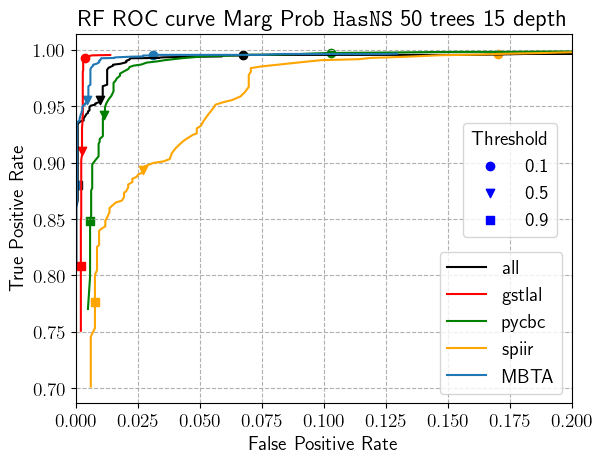

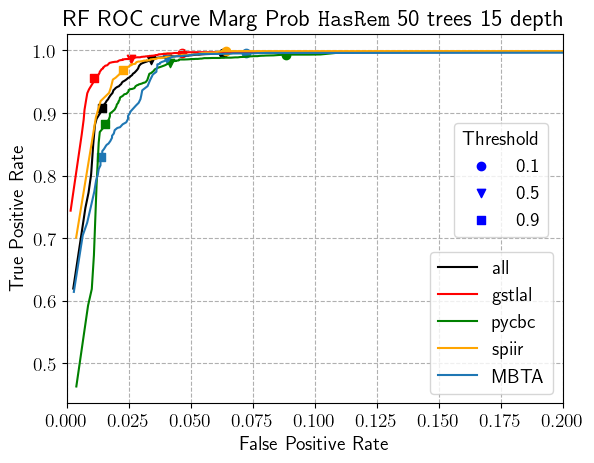

In [63]:
plt.figure()

plt.xlim([0,.2])
#plt.ylim([0.96,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasNS} 50 trees 15 depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'50t15d_NS.png',dpi=300, facecolor='w')
plt.show()

plt.figure()

#plt.ylim([0.90,1])
plt.xlim([0,.2])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasRem} 50 trees 15 depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events_store[p_events_store['EMB_SLy']>0]
    non_HasREM = p_events_store[p_events_store['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'50t15d_REM.png',dpi=300, facecolor='w')
plt.show()

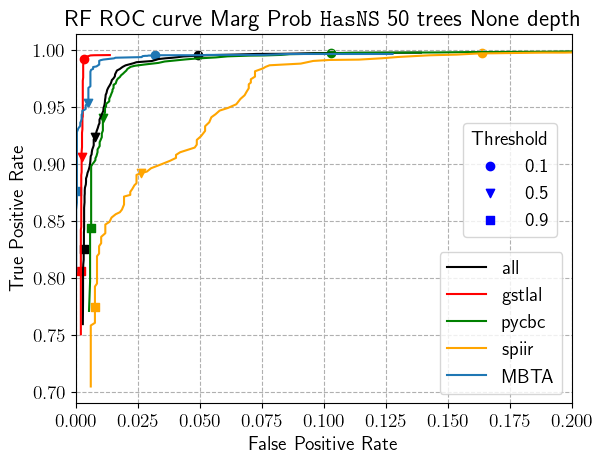

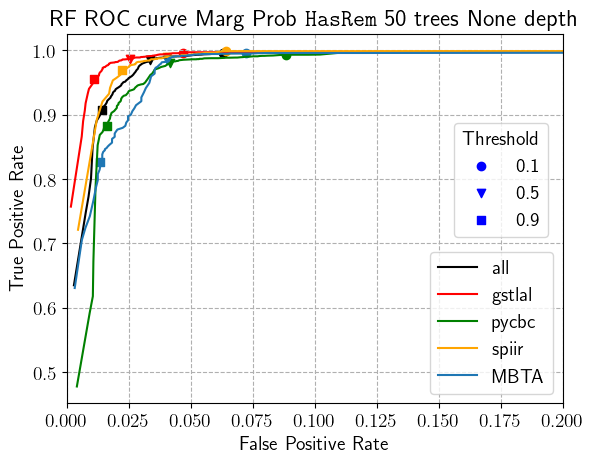

In [66]:
pathTrees = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\Forest_O2_70-30_50trees_Nonedepth\\"
#Load the forests
EOSdicRF = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadModel(pathTrees, eos)
    new_dic = {}
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdicRF[eos] = new_dic
    count = count + 1

#Predict the MDC with the forests
columns = df[['mass1', 'mass2', 'spin1z', 'spin2z', 'combined_snr']]
for eos in EOS:
    predictions = EOSdicRF[eos]['forest'].model.predict_proba(columns.values)
    pred_NS = 1-predictions[:,0]
    pred_REM = predictions[:,2]
    EOSdicRF[eos]['prob_NS'] = pred_NS
    EOSdicRF[eos]['prob_REM'] = pred_REM

#Marginalize all probabilities
marg_NS = np.zeros(len(pred_NS))
marg_REM = np.zeros(len(pred_REM))
for eos in EOS:
    marg_NS = marg_NS + EOSdicRF[eos]['prob_NS']*EOSdicRF[eos]['weight']
    marg_REM = marg_REM + EOSdicRF[eos]['prob_REM']*EOSdicRF[eos]['weight']
marg_NS = marg_NS / totalBF
marg_REM = marg_REM / totalBF

df['P_NS'] = marg_NS 
df['P_REM'] = marg_REM

p_events = df
p_events_store = p_events

plt.figure()

plt.xlim([0,.2])
#plt.ylim([0.96,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasNS} 50 trees None depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'50tNd_NS.png',dpi=300, facecolor='w')
plt.show()

plt.figure()

#plt.ylim([0.90,1])
plt.xlim([0,.2])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasRem} 50 trees None depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events_store[p_events_store['EMB_SLy']>0]
    non_HasREM = p_events_store[p_events_store['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'50tNd_REM.png',dpi=300, facecolor='w')
plt.show()

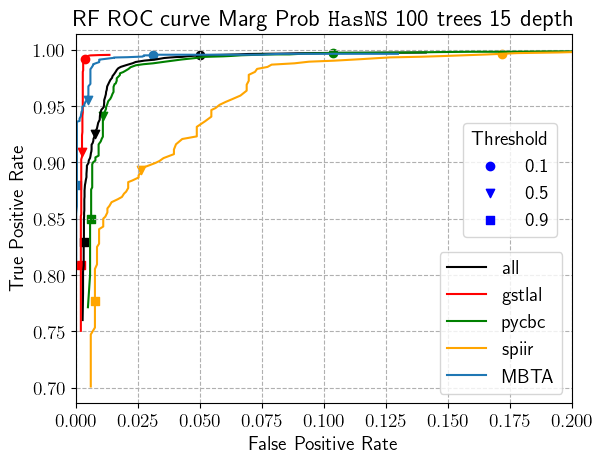

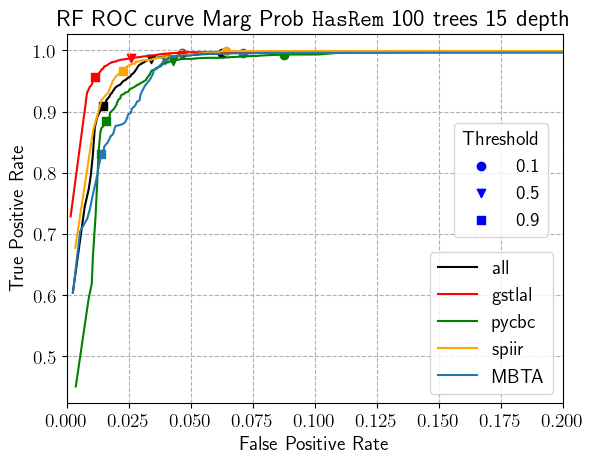

In [65]:
pathTrees = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\Forest_O2_70-30_100trees_15depth\\"
#Load the forests
EOSdicRF = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadModel(pathTrees, eos)
    new_dic = {}
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdicRF[eos] = new_dic
    count = count + 1

#Predict the MDC with the forests
columns = df[['mass1', 'mass2', 'spin1z', 'spin2z', 'combined_snr']]
for eos in EOS:
    predictions = EOSdicRF[eos]['forest'].model.predict_proba(columns.values)
    pred_NS = 1-predictions[:,0]
    pred_REM = predictions[:,2]
    EOSdicRF[eos]['prob_NS'] = pred_NS
    EOSdicRF[eos]['prob_REM'] = pred_REM

#Marginalize all probabilities
marg_NS = np.zeros(len(pred_NS))
marg_REM = np.zeros(len(pred_REM))
for eos in EOS:
    marg_NS = marg_NS + EOSdicRF[eos]['prob_NS']*EOSdicRF[eos]['weight']
    marg_REM = marg_REM + EOSdicRF[eos]['prob_REM']*EOSdicRF[eos]['weight']
marg_NS = marg_NS / totalBF
marg_REM = marg_REM / totalBF

df['P_NS'] = marg_NS 
df['P_REM'] = marg_REM

p_events = df
p_events_store = p_events

plt.figure()

plt.xlim([0,.2])
#plt.ylim([0.96,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasNS} 100 trees 15 depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'100t15d_NS.png',dpi=300, facecolor='w')
plt.show()

plt.figure()

#plt.ylim([0.90,1])
plt.xlim([0,.2])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasRem} 100 trees 15 depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events_store[p_events_store['EMB_SLy']>0]
    non_HasREM = p_events_store[p_events_store['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'100t15d_REM.png',dpi=300, facecolor='w')
plt.show()

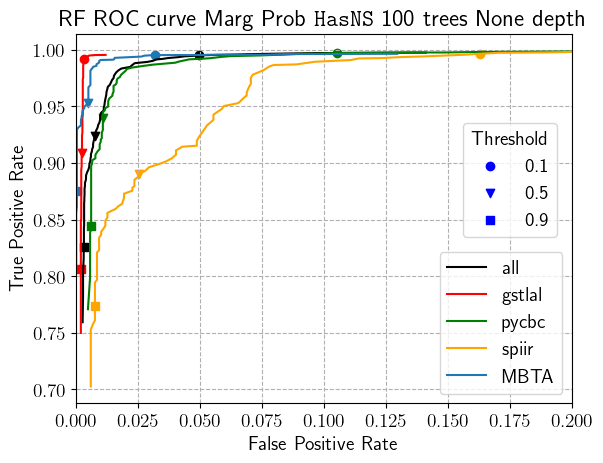

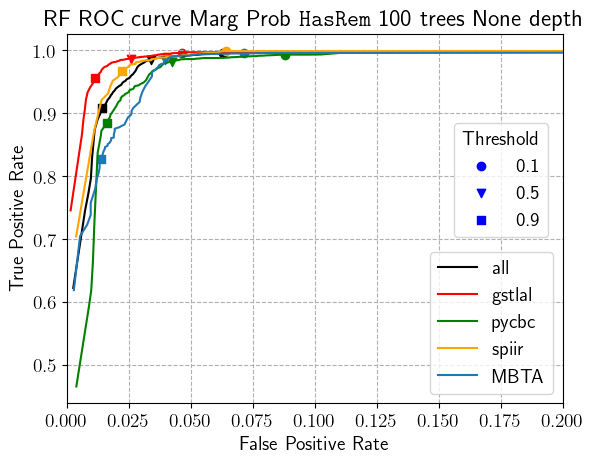

In [67]:
pathTrees = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\Forest_O2_70-30_100trees_Nonedepth\\"
#Load the forests
EOSdicRF = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadModel(pathTrees, eos)
    new_dic = {}
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdicRF[eos] = new_dic
    count = count + 1

#Predict the MDC with the forests
columns = df[['mass1', 'mass2', 'spin1z', 'spin2z', 'combined_snr']]
for eos in EOS:
    predictions = EOSdicRF[eos]['forest'].model.predict_proba(columns.values)
    pred_NS = 1-predictions[:,0]
    pred_REM = predictions[:,2]
    EOSdicRF[eos]['prob_NS'] = pred_NS
    EOSdicRF[eos]['prob_REM'] = pred_REM

#Marginalize all probabilities
marg_NS = np.zeros(len(pred_NS))
marg_REM = np.zeros(len(pred_REM))
for eos in EOS:
    marg_NS = marg_NS + EOSdicRF[eos]['prob_NS']*EOSdicRF[eos]['weight']
    marg_REM = marg_REM + EOSdicRF[eos]['prob_REM']*EOSdicRF[eos]['weight']
marg_NS = marg_NS / totalBF
marg_REM = marg_REM / totalBF

df['P_NS'] = marg_NS 
df['P_REM'] = marg_REM

p_events = df
p_events_store = p_events

plt.figure()

plt.xlim([0,.2])
#plt.ylim([0.96,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasNS} 100 trees None depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'100tNd_NS.png',dpi=300, facecolor='w')
plt.show()

plt.figure()

#plt.ylim([0.90,1])
plt.xlim([0,.2])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasRem} 100 trees None depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events_store[p_events_store['EMB_SLy']>0]
    non_HasREM = p_events_store[p_events_store['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'100tNd_REM.png',dpi=300, facecolor='w')
plt.show()

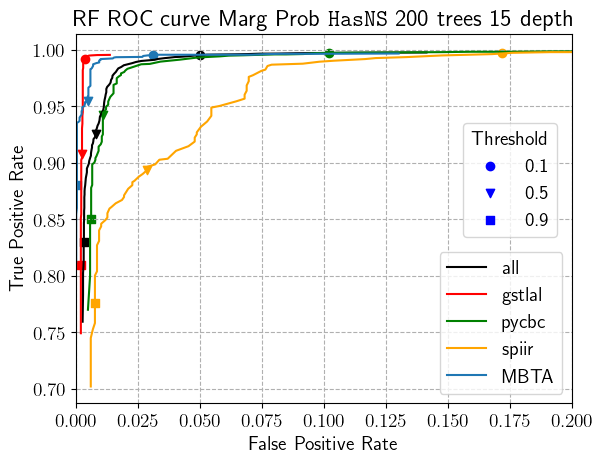

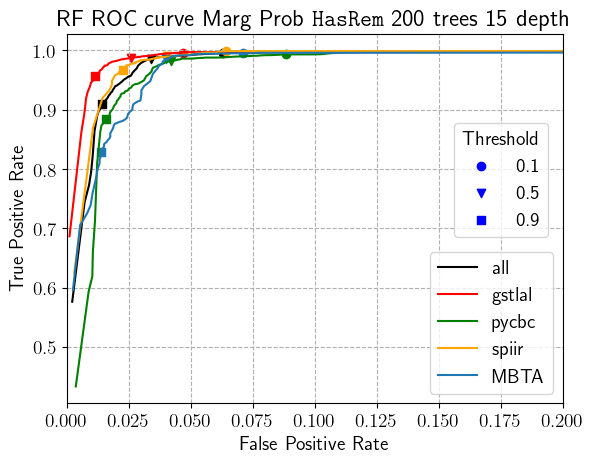

In [68]:
pathTrees = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\Forest_O2_70-30_200trees_15depth\\"
#Load the forests
EOSdicRF = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadModel(pathTrees, eos)
    new_dic = {}
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdicRF[eos] = new_dic
    count = count + 1

#Predict the MDC with the forests
columns = df[['mass1', 'mass2', 'spin1z', 'spin2z', 'combined_snr']]
for eos in EOS:
    predictions = EOSdicRF[eos]['forest'].model.predict_proba(columns.values)
    pred_NS = 1-predictions[:,0]
    pred_REM = predictions[:,2]
    EOSdicRF[eos]['prob_NS'] = pred_NS
    EOSdicRF[eos]['prob_REM'] = pred_REM

#Marginalize all probabilities
marg_NS = np.zeros(len(pred_NS))
marg_REM = np.zeros(len(pred_REM))
for eos in EOS:
    marg_NS = marg_NS + EOSdicRF[eos]['prob_NS']*EOSdicRF[eos]['weight']
    marg_REM = marg_REM + EOSdicRF[eos]['prob_REM']*EOSdicRF[eos]['weight']
marg_NS = marg_NS / totalBF
marg_REM = marg_REM / totalBF

df['P_NS'] = marg_NS 
df['P_REM'] = marg_REM

p_events = df
p_events_store = p_events

plt.figure()

plt.xlim([0,.2])
#plt.ylim([0.96,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasNS} 200 trees 15 depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'200t15d_NS.png',dpi=300, facecolor='w')
plt.show()

plt.figure()

#plt.ylim([0.90,1])
plt.xlim([0,.2])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasRem} 200 trees 15 depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events_store[p_events_store['EMB_SLy']>0]
    non_HasREM = p_events_store[p_events_store['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'200t15d_REM.png',dpi=300, facecolor='w')
plt.show()

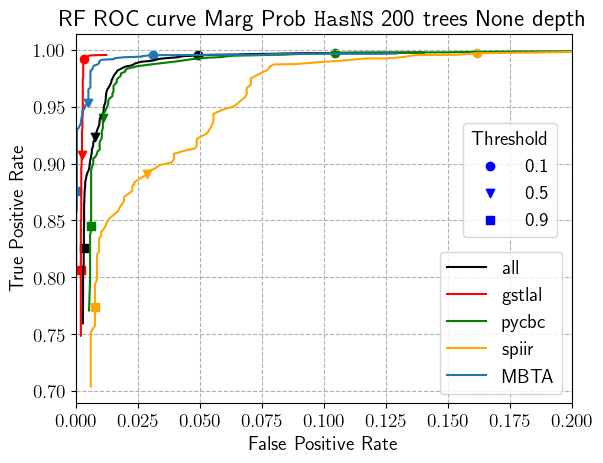

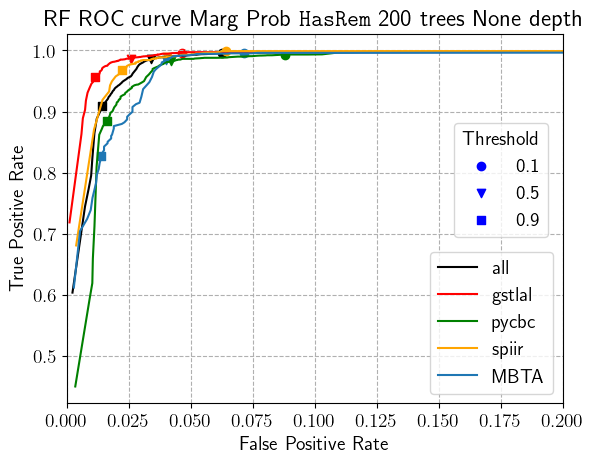

In [69]:
pathTrees = "C:\\Users\\marin\\Desktop\\ML_workingGroup\\FINAL\\Forest_O2_70-30_200trees_Nonedepth\\"
#Load the forests
EOSdicRF = {}
count = 0
for eos in EOS:
    RF = classyRF.ClassificationRF()
    RF.loadModel(pathTrees, eos)
    new_dic = {}
    new_dic['forest'] = RF
    new_dic['weight'] = BayesFactor[count]
    EOSdicRF[eos] = new_dic
    count = count + 1

#Predict the MDC with the forests
columns = df[['mass1', 'mass2', 'spin1z', 'spin2z', 'combined_snr']]
for eos in EOS:
    predictions = EOSdicRF[eos]['forest'].model.predict_proba(columns.values)
    pred_NS = 1-predictions[:,0]
    pred_REM = predictions[:,2]
    EOSdicRF[eos]['prob_NS'] = pred_NS
    EOSdicRF[eos]['prob_REM'] = pred_REM

#Marginalize all probabilities
marg_NS = np.zeros(len(pred_NS))
marg_REM = np.zeros(len(pred_REM))
for eos in EOS:
    marg_NS = marg_NS + EOSdicRF[eos]['prob_NS']*EOSdicRF[eos]['weight']
    marg_REM = marg_REM + EOSdicRF[eos]['prob_REM']*EOSdicRF[eos]['weight']
marg_NS = marg_NS / totalBF
marg_REM = marg_REM / totalBF

df['P_NS'] = marg_NS 
df['P_REM'] = marg_REM

p_events = df
p_events_store = p_events

plt.figure()

plt.xlim([0,.2])
#plt.ylim([0.96,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasNS} 200 trees None depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(non_HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []    
for pns in np.linspace(0,1,101)[1:-1]:
    HasNS = p_events[p_events['NS_SLy']>0]
    non_HasNS = p_events[p_events['NS_SLy']<1]
    true_positives = HasNS[HasNS['P_NS']>=pns]
    false_positives = non_HasNS[non_HasNS['P_NS']>=pns]
    tpr = len(true_positives)/len(HasNS)
    fpr = len(false_positives)/len(HasNS)
    TP.append(tpr)
    FP.append(fpr)
    if (pns == 0.1 or pns == 0.5 or pns ==0.9):
        points.append([pns, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'200tNd_NS.png',dpi=300, facecolor='w')
plt.show()

plt.figure()

#plt.ylim([0.90,1])
plt.xlim([0,.2])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(r"RF ROC curve Marg Prob \texttt{HasRem} 200 trees None depth")
plt.grid(ls='--')

TP = []
FP = []
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events_store[p_events_store['EMB_SLy']>0]
    non_HasREM = p_events_store[p_events_store['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP, TP, c='black', label='all')
plt.scatter(points[0][1], points[0][2],marker='o', c='black')
plt.scatter(points[1][1], points[1][2],marker='v', c='black')
plt.scatter(points[2][1], points[2][2],marker='s', c='black')

p_events = p_events_store[p_events_store['pipeline']=='gstlal']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='red', label='gstlal')
plt.scatter(points[0][1], points[0][2],marker='o', c='red')
plt.scatter(points[1][1], points[1][2],marker='v', c='red')
plt.scatter(points[2][1], points[2][2],marker='s', c='red')

p_events = p_events_store[p_events_store['pipeline']=='pycbc']
TP = []
FP = [] 
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='green', label='pycbc')
plt.scatter(points[0][1], points[0][2],marker='o', c='green')
plt.scatter(points[1][1], points[1][2],marker='v', c='green')
plt.scatter(points[2][1], points[2][2],marker='s', c='green')

p_events = p_events_store[p_events_store['pipeline']=='spiir']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,c='orange', label='spiir')
plt.scatter(points[0][1], points[0][2],marker='o', c='orange')
plt.scatter(points[1][1], points[1][2],marker='v', c='orange')
plt.scatter(points[2][1], points[2][2],marker='s', c='orange')

p_events = p_events_store[p_events_store['pipeline']=='MBTA']
TP = []
FP = []   
points = []
for prem in np.linspace(0,1,101):
    HasREM = p_events[p_events['EMB_SLy']>0]
    non_HasREM = p_events[p_events['EMB_SLy']<1]
    true_positives = HasREM[HasREM['P_REM']>=prem]
    false_positives = non_HasREM[non_HasREM['P_REM']>=prem]
    tpr = len(true_positives)/len(HasREM)
    fpr = len(false_positives)/len(non_HasREM) #fixed
    TP.append(tpr)
    FP.append(fpr)
    if (prem == 0.1 or prem == 0.5 or prem ==0.9):
        points.append([prem, fpr, tpr])
pns_roc = plt.plot(FP,TP,label='MBTA',c='#1f77b4')
plt.scatter(points[0][1], points[0][2],marker='o',c='#1f77b4')
plt.scatter(points[1][1], points[1][2],marker='v',c='#1f77b4')
plt.scatter(points[2][1], points[2][2],marker='s',c='#1f77b4')

points1 = plt.scatter(-1,0.9,c='blue',marker='o')
points2 = plt.scatter(-1,0.9,c='blue',marker='v')
points3 = plt.scatter(-1,0.9,c='blue',marker='s')
legend1 = plt.legend([points1, points2, points3], ["0.1", "0.5", "0.9"], loc= (0.78,0.45), title="Threshold")
plt.gca().add_artist(legend1)
plt.legend()
#plt.legend(custom_legend, ['All', 'gstlal', 'pycbc', 'spiir', 'MBTA'], loc='lower right', fontsize=15)
    
plt.savefig(pathPlots+'200tNd_REM.png',dpi=300, facecolor='w')
plt.show()